In [114]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from openparticle import ParticleOperator, Fock, generate_matrix
import numpy as np
import math
import cirq
from time import time
import matplotlib.pyplot as plt
from src.lobe.system import System
from src.lobe.block_encoding import add_lobe_oracle
from cirq.contrib.svg import SVGCircuit
from src.lobe.usp import add_naive_usp
from src.lobe.asp import add_prepare_circuit, get_target_state
from src.lobe.rescale import bosonically_rescale_terms, rescale_terms_usp, get_number_of_active_bosonic_modes
from src.lobe._utils import get_basis_of_full_system
from colors import *

In [115]:
N = 200
n = 3
g = 1

In [116]:
def one_ge(matrix):
    n = len(matrix) - 1
    A_eff = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            A_eff[i][j] = matrix[i][j] - g * (matrix[i][n] * matrix[n][j])/(matrix[n][n])

    return A_eff

def ge_matrix(matrix, n):

    N = len(matrix)

    for _ in range(N - n):
        matrix = one_ge(matrix)

    return matrix

In [117]:
def matel(k, l, g):
    return (k + 3 * g * (2 * k ** 2 + 2 * k + 1)) * check_delta(k, l) +\
            g * (4 * l + 6) * np.sqrt((l + 1) * (l + 2)) * check_delta(k, l + 2) +\
            g * (4 * k + 6) * np.sqrt((k + 1) * (k + 2)) * check_delta(k + 2, l) +\
            g * np.sqrt((l + 1) * (l + 2) * (l + 3) * (l + 4)) * check_delta(k, l + 4) +\
            g * np.sqrt((k + 1) * (k + 2) * (k + 3) * (k + 4)) * check_delta(k + 4, l) 

def check_delta(k, l):
    if k == l: return 1 
    return 0

In [118]:
def get_Hfull(N):
    Hfull = np.zeros((N + 1, N + 1))

    for i in range(N + 1):
        for j in range(N + 1):
            Hfull[i][j] = matel(i, j, g)
    return Hfull

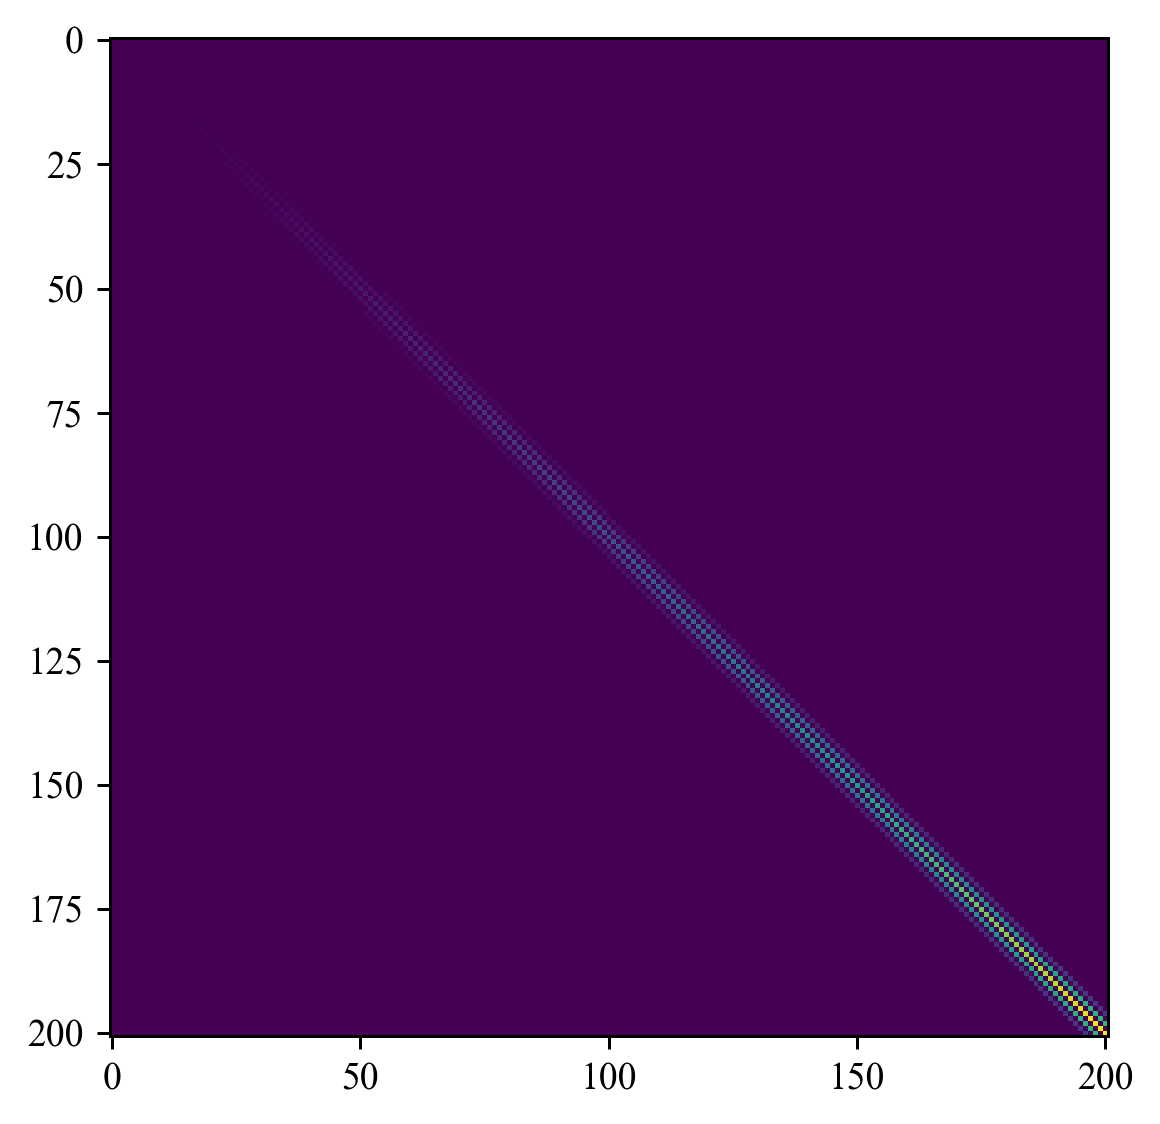

In [119]:
Hfull = np.zeros((N + 1, N + 1))

for i in range(N + 1):
    for j in range(N + 1):
        Hfull[i][j] = matel(i, j, g)
vals, vecs = np.linalg.eigh(Hfull)


plt.imshow(Hfull)

In [120]:
def get_basis(N):
    return [Fock([], [], [(0, l)]) for l in range(N + 1)]

In [121]:
H = ParticleOperator('a0^ a0') + g * (ParticleOperator('a0^') + ParticleOperator('a0'))**4

In [122]:
from openparticle.utils import get_matrix_element, overlap

In [163]:
def better_overlap(i, j):
    key_overlap = i.state_dict.keys() & j.state_dict.keys()
    if key_overlap == {}:
        return 0
    else:
        overlap = 0
        for key in key_overlap:
            overlap += i.state_dict[key] * j.state_dict[key]

        return overlap

In [164]:
basis = get_basis(7)
better_overlap(basis[6], H * basis[4])

120.49896265113657

In [165]:
def better_matrix_generation(N):
    H = ParticleOperator('a0^ a0') + g * (ParticleOperator('a0^') + ParticleOperator('a0'))**4
    basis = get_basis(N)
    matrix = np.zeros((N + 1, N + 1), dtype=complex)

    for j, state_j in enumerate(basis):
        rhs = H * state_j
        for i, state_i in enumerate(basis):
            if i <= j:
                mval = better_overlap(state_i, rhs)
                matrix[i][j] = matrix[j][i] = mval

    return matrix


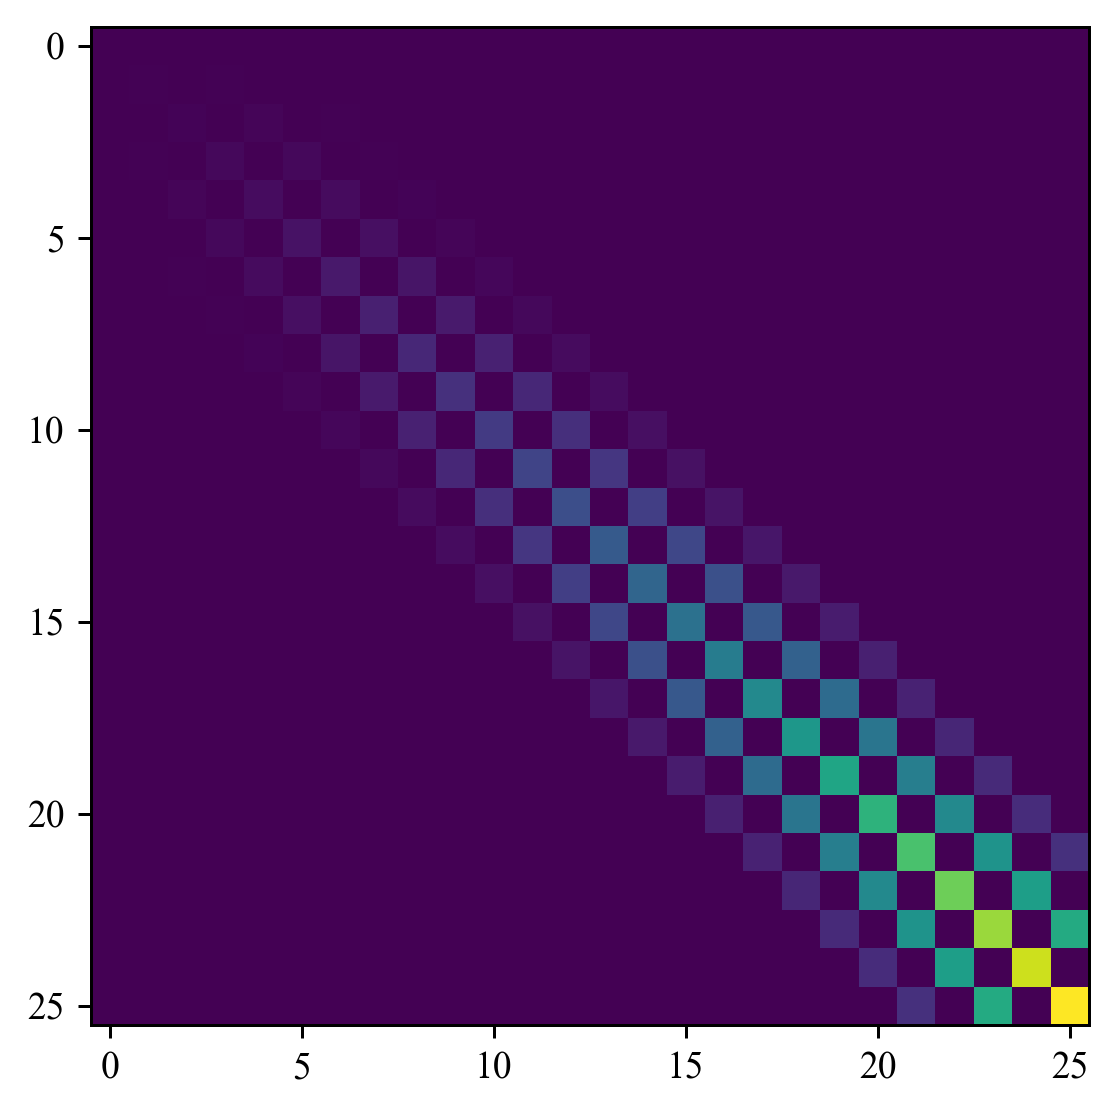

In [168]:
plt.imshow(np.real(better_matrix_generation(25)))

In [105]:
np.allclose(
    get_Hfull(7),
    generate_matrix(H, get_basis(7))
)

True

In [106]:
def Hren_op(full_matrix, n):
    H = ParticleOperator('a0^ a0') + g * (ParticleOperator('a0^') + ParticleOperator('a0'))**4

    Heff = ge_matrix(full_matrix, n + 1)
    basis = [Fock([], [], [(0, l)]) for l in range(n + 1)]

    def delta_H(i, j):
        return (Heff[:,:])[i,j] - full_matrix[i,j]
    
    H_eff_op = H + (
        delta_H(n - 3, n - 3) / math.factorial(n - 3) * ParticleOperator('a0^') ** (n - 3) * ParticleOperator('a0') ** (n - 3) - 
        delta_H(n - 3, n - 3) / math.factorial(n - 3) * (ParticleOperator('a0^') ** (n - 2) * ParticleOperator('a0') ** (n - 2)) +
        delta_H(n - 3, n - 3) / (2 * math.factorial(n - 3)) * (ParticleOperator('a0^') ** (n - 1) * ParticleOperator('a0') ** (n - 1)) -
        delta_H(n - 3, n - 3) / (6 * math.factorial(n - 3)) * (ParticleOperator('a0^') ** n * ParticleOperator('a0') ** n) + 
        delta_H(n - 1, n - 1) / math.factorial(n - 1) * (ParticleOperator('a0^') ** (n - 1) * ParticleOperator('a0') ** (n - 1)) -
        delta_H(n - 1, n - 1) / math.factorial(n - 1) * (ParticleOperator('a0^') ** n * ParticleOperator('a0') ** n) + 
        (delta_H(n - 3, n - 1) / math.sqrt(math.factorial(n - 3) * math.factorial(n - 1))) * (
            ParticleOperator('a0^') ** (n - 3) * ParticleOperator('a0') ** (n - 1) - ParticleOperator('a0^') ** (n - 2) * ParticleOperator('a0') ** n
        ) +
        (delta_H(n - 1, n - 3) / math.sqrt(math.factorial(n - 3) * math.factorial(n - 1))) * (
            ParticleOperator('a0^') ** (n - 1) * ParticleOperator('a0') ** (n - 3) - ParticleOperator('a0^') ** n * ParticleOperator('a0') ** (n - 2)
        ) + 
        delta_H(n - 2, n - 2) / math.factorial(n - 2) * ParticleOperator('a0^') ** (n - 2) * ParticleOperator('a0') ** (n - 2) - 
        delta_H(n - 2, n - 2) / math.factorial(n - 2) * (ParticleOperator('a0^') ** (n - 1) * ParticleOperator('a0') ** (n - 1)) +
        delta_H(n - 2, n - 2) / (2 * math.factorial(n - 2)) * (ParticleOperator('a0^') ** n * ParticleOperator('a0') ** n) -
        delta_H(n - 2, n - 2) / (6 * math.factorial(n - 2)) * (ParticleOperator('a0^') ** (n + 1) * ParticleOperator('a0') ** (n + 1)) + 
        delta_H(n, n) / math.factorial(n) * (ParticleOperator('a0^') ** n * ParticleOperator('a0') ** n) -
        delta_H(n, n) / math.factorial(n) * (ParticleOperator('a0^') ** (n + 1) * ParticleOperator('a0') ** (n + 1)) + 
        (delta_H(n - 2, n) / math.sqrt(math.factorial(n - 2) * math.factorial(n))) * (
            ParticleOperator('a0^') ** (n - 2) * ParticleOperator('a0') ** n - ParticleOperator('a0^') ** (n - 1) * ParticleOperator('a0') ** (n + 1)
        ) +
        (delta_H(n, n - 2) / math.sqrt(math.factorial(n - 2) * math.factorial(n))) * (
            ParticleOperator('a0^') ** n * ParticleOperator('a0') ** (n - 2) - ParticleOperator('a0^') ** (n + 1) * ParticleOperator('a0') ** (n - 1)
        )
    )
    H_eff_op = ParticleOperator(H_eff_op.normal_order().op_dict)

    energy_shift = 0
    if '' in H_eff_op.op_dict.keys():
        energy_shift += H_eff_op.op_dict['']
    elif ' ' in H_eff_op.op_dict.keys():
        energy_shift += H_eff_op.op_dict[' ']


    H_eff_op.remove_identity()
    return H_eff_op, energy_shift


In [107]:
import math

In [108]:
n = 3
Hren_op(Hfull, 2**n - 1)[0]


1.0 * a0^ a0^ a0^ a0^
4.0 * a0^ a0^ a0^ a0
6.0 * a0^ a0^
6.0 * a0^ a0^ a0 a0
13.0 * a0^ a0
4.0 * a0^ a0 a0 a0
6.0 * a0 a0
1.0 * a0 a0 a0 a0
-0.4593524169670348 * a0^ a0^ a0^ a0^ a0 a0 a0 a0
0.3250672728004602 * a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0
-0.32996340051351536 * a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0
0.19924996545999313 * a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0 a0
-0.3058454848451082 * a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0
0.23358924504901207 * a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0 a0
-0.3058454848451082 * a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0
0.23358924504901207 * a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0
0.06711939217556037 * a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0 a0 a0
0.07225623979609615 * a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0 a0 a0
0.07225623979609615 * a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0

In [111]:
evals = []
Estar = min(np.linalg.eigvalsh(Hfull))
for nstar in [2, 3]:
    h , deltaE = Hren_op(Hfull, 2**nstar - 1)
    Heff_from_op = generate_matrix(h, basis[:2**nstar - 1 + 1])
    evals.append(np.abs(Estar - (min(np.linalg.eigvalsh(Heff_from_op)) + deltaE)))

In [112]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 270

Text(0, 0.5, '$|\\lambda^* - \\tilde \\lambda_n|$')

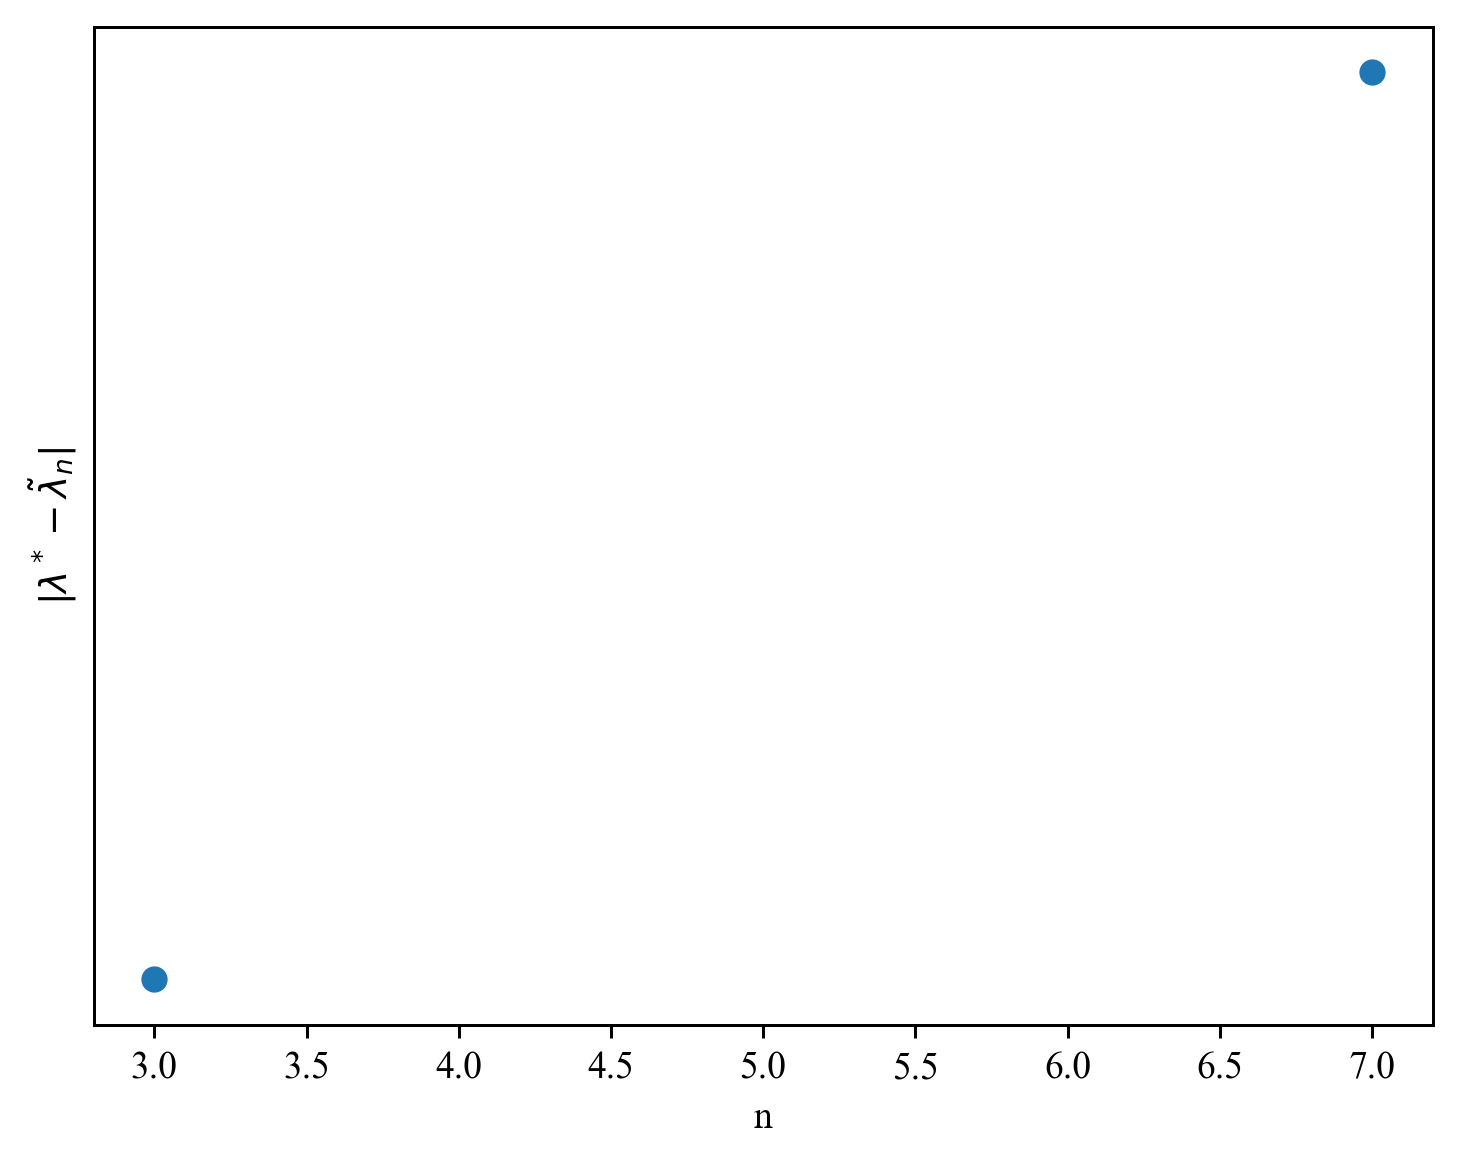

In [113]:
plt.scatter([2**2 - 1, 2**3 - 1], evals)
plt.yscale('symlog', linthresh = 1e-12)
plt.xlabel('n')
plt.ylabel(r'$|\lambda^* - \tilde \lambda_n|$')

In [35]:
def generate_full_qosc_circuit(maximum_bosonic_occupation):

    operator =  ParticleOperator('a0^ a0') + g * (ParticleOperator('a0^') + ParticleOperator('a0'))**4
    terms = operator.to_list()

    bosonically_rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(terms, maximum_bosonic_occupation)
    coefficients = [term.coeff for term in bosonically_rescaled_terms]


    norm = sum(np.abs(coefficients))
    target_state = get_target_state(coefficients)
    asp_rescaling_factor = (bosonic_rescaling_factor * norm)

    number_of_modes = max([term.max_mode() for term in terms]) + 1

    number_of_ancillae = (
        1000  # Some arbitrary large number with most ancilla disregarded
    )
    number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
    number_of_rotation_qubits = max(get_number_of_active_bosonic_modes(terms)) + 1
    
    usp_rescaled_terms, usp_rescaling_factor = rescale_terms_usp(bosonically_rescaled_terms)
    usp_rescaling_factor *= (bosonic_rescaling_factor * (1 << number_of_index_qubits))

    # Declare Qubits
    validation = cirq.LineQubit(0)
    clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
    rotation_qubits = [
        cirq.LineQubit(i + 1 + number_of_ancillae)
        for i in range(number_of_rotation_qubits)
    ]
    index_register = [
        cirq.LineQubit(i + 1 + number_of_ancillae + number_of_rotation_qubits)
        for i in range(number_of_index_qubits)
    ]
    system = System(
        number_of_modes=number_of_modes,
        maximum_occupation_number=maximum_bosonic_occupation,
        number_of_used_qubits=1
        + number_of_ancillae
        + number_of_rotation_qubits
        + number_of_index_qubits,
        has_fermions=operator.has_fermions,
        has_antifermions=operator.has_antifermions,
        has_bosons=operator.has_bosons,
    )
    
    #### USP Circuit Generation
    USP_numerics = {
        "left_elbows": 0,
        "right_elbows": 0,
        "rotations": 0,
        "ancillae_tracker": [1 + number_of_rotation_qubits + number_of_index_qubits],
        "angles": [],
        "number_of_nonclifford_rotations": 0,
        "rescaling_factor": usp_rescaling_factor,
        "number_of_modes": number_of_modes,
        "maximum_bosonic_occupation": maximum_bosonic_occupation,
        "maximum_number_of_active_bosonic_modes": number_of_rotation_qubits - 1,
        "number_of_terms": len(terms),
    }
    circuit = cirq.Circuit()
    circuit.append(cirq.I.on_each(*system.fermionic_register))
    circuit.append(cirq.I.on_each(*system.antifermionic_register))
    for bosonic_reg in system.bosonic_system:
        circuit.append(cirq.I.on_each(*bosonic_reg))
    circuit.append(cirq.X.on(validation))
    circuit += add_naive_usp(index_register)
    circuit += add_lobe_oracle(
        usp_rescaled_terms,
        validation,
        index_register,
        system,
        rotation_qubits,
        clean_ancillae,
        perform_coefficient_oracle=True,
        decompose=True,
        numerics=USP_numerics,
    )
    circuit += add_naive_usp(index_register)
    USP_numerics["number_of_ancillae"] = max(USP_numerics["ancillae_tracker"])
    USP_numerics["number_of_qubits"] = max(USP_numerics["ancillae_tracker"]) + system.number_of_system_qubits
    for angle in USP_numerics["angles"]:
        angle = np.abs(angle)
        if not np.isclose(angle%np.pi/4, 0):
            USP_numerics["number_of_nonclifford_rotations"] += 1
    
    
    #### ASP Circuit Generation
    ASP_numerics = {
        "left_elbows": 0,
        "right_elbows": 0,
        "rotations": 0,
        "ancillae_tracker": [1 + number_of_rotation_qubits - 1 + number_of_index_qubits],
        "angles": [],
        "number_of_nonclifford_rotations": 0,
        "rescaling_factor": asp_rescaling_factor,
        "number_of_modes": number_of_modes,
        "maximum_bosonic_occupation": maximum_bosonic_occupation,
        "maximum_number_of_active_bosonic_modes": number_of_rotation_qubits - 1,
        "number_of_terms": len(terms)
    }
    circuit = cirq.Circuit()
    circuit.append(cirq.I.on_each(*system.fermionic_register))
    circuit.append(cirq.I.on_each(*system.antifermionic_register))
    for bosonic_reg in system.bosonic_system:
        circuit.append(cirq.I.on_each(*bosonic_reg))
    circuit.append(cirq.X.on(validation))
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    circuit += add_lobe_oracle(
        bosonically_rescaled_terms,
        validation,
        index_register,
        system,
        rotation_qubits,
        clean_ancillae,
        perform_coefficient_oracle=False,
        decompose=True,
        numerics=ASP_numerics,
    )
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        dagger=True,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    ASP_numerics["number_of_ancillae"] = max(ASP_numerics["ancillae_tracker"])
    ASP_numerics["number_of_qubits"] = max(ASP_numerics["ancillae_tracker"]) + system.number_of_system_qubits
    for angle in ASP_numerics["angles"]:
        angle = np.abs(angle)
        if not np.isclose(angle%np.pi/4, 0):
            ASP_numerics["number_of_nonclifford_rotations"] += 1
    
    return {
        "USP": USP_numerics,
        "ASP": ASP_numerics 
    }

In [36]:
def generate_qosc_circuit(maximum_bosonic_occupation):

    operator =  Hren_op(Hfull, maximum_bosonic_occupation)[0]
    terms = operator.to_list()

    bosonically_rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(terms, maximum_bosonic_occupation)
    coefficients = [term.coeff for term in bosonically_rescaled_terms]


    norm = sum(np.abs(coefficients))
    target_state = get_target_state(coefficients)
    asp_rescaling_factor = (bosonic_rescaling_factor * norm)

    number_of_modes = max([term.max_mode() for term in terms]) + 1

    number_of_ancillae = (
        1000  # Some arbitrary large number with most ancilla disregarded
    )
    number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
    number_of_rotation_qubits = max(get_number_of_active_bosonic_modes(terms)) + 1
    
    usp_rescaled_terms, usp_rescaling_factor = rescale_terms_usp(bosonically_rescaled_terms)
    usp_rescaling_factor *= (bosonic_rescaling_factor * (1 << number_of_index_qubits))

    # Declare Qubits
    validation = cirq.LineQubit(0)
    clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
    rotation_qubits = [
        cirq.LineQubit(i + 1 + number_of_ancillae)
        for i in range(number_of_rotation_qubits)
    ]
    index_register = [
        cirq.LineQubit(i + 1 + number_of_ancillae + number_of_rotation_qubits)
        for i in range(number_of_index_qubits)
    ]
    system = System(
        number_of_modes=number_of_modes,
        maximum_occupation_number=maximum_bosonic_occupation,
        number_of_used_qubits=1
        + number_of_ancillae
        + number_of_rotation_qubits
        + number_of_index_qubits,
        has_fermions=operator.has_fermions,
        has_antifermions=operator.has_antifermions,
        has_bosons=operator.has_bosons,
    )
    
    #### USP Circuit Generation
    USP_numerics = {
        "left_elbows": 0,
        "right_elbows": 0,
        "rotations": 0,
        "ancillae_tracker": [1 + number_of_rotation_qubits + number_of_index_qubits],
        "angles": [],
        "number_of_nonclifford_rotations": 0,
        "rescaling_factor": usp_rescaling_factor,
        "number_of_modes": number_of_modes,
        "maximum_bosonic_occupation": maximum_bosonic_occupation,
        "maximum_number_of_active_bosonic_modes": number_of_rotation_qubits - 1,
        "number_of_terms": len(terms),
    }
    circuit = cirq.Circuit()
    circuit.append(cirq.I.on_each(*system.fermionic_register))
    circuit.append(cirq.I.on_each(*system.antifermionic_register))
    for bosonic_reg in system.bosonic_system:
        circuit.append(cirq.I.on_each(*bosonic_reg))
    circuit.append(cirq.X.on(validation))
    circuit += add_naive_usp(index_register)
    circuit += add_lobe_oracle(
        usp_rescaled_terms,
        validation,
        index_register,
        system,
        rotation_qubits,
        clean_ancillae,
        perform_coefficient_oracle=True,
        decompose=True,
        numerics=USP_numerics,
    )
    circuit += add_naive_usp(index_register)
    USP_numerics["number_of_ancillae"] = max(USP_numerics["ancillae_tracker"])
    USP_numerics["number_of_qubits"] = max(USP_numerics["ancillae_tracker"]) + system.number_of_system_qubits
    for angle in USP_numerics["angles"]:
        angle = np.abs(angle)
        if not np.isclose(angle%np.pi/4, 0):
            USP_numerics["number_of_nonclifford_rotations"] += 1
    
    
    #### ASP Circuit Generation
    ASP_numerics = {
        "left_elbows": 0,
        "right_elbows": 0,
        "rotations": 0,
        "ancillae_tracker": [1 + number_of_rotation_qubits - 1 + number_of_index_qubits],
        "angles": [],
        "number_of_nonclifford_rotations": 0,
        "rescaling_factor": asp_rescaling_factor,
        "number_of_modes": number_of_modes,
        "maximum_bosonic_occupation": maximum_bosonic_occupation,
        "maximum_number_of_active_bosonic_modes": number_of_rotation_qubits - 1,
        "number_of_terms": len(terms)
    }
    circuit = cirq.Circuit()
    circuit.append(cirq.I.on_each(*system.fermionic_register))
    circuit.append(cirq.I.on_each(*system.antifermionic_register))
    for bosonic_reg in system.bosonic_system:
        circuit.append(cirq.I.on_each(*bosonic_reg))
    circuit.append(cirq.X.on(validation))
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    circuit += add_lobe_oracle(
        bosonically_rescaled_terms,
        validation,
        index_register,
        system,
        rotation_qubits,
        clean_ancillae,
        perform_coefficient_oracle=False,
        decompose=True,
        numerics=ASP_numerics,
    )
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        dagger=True,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    ASP_numerics["number_of_ancillae"] = max(ASP_numerics["ancillae_tracker"])
    ASP_numerics["number_of_qubits"] = max(ASP_numerics["ancillae_tracker"]) + system.number_of_system_qubits
    for angle in ASP_numerics["angles"]:
        angle = np.abs(angle)
        if not np.isclose(angle%np.pi/4, 0):
            ASP_numerics["number_of_nonclifford_rotations"] += 1
    
    return {
        "USP": USP_numerics,
        "ASP": ASP_numerics 
    }

In [37]:
occupation_cutoff_range = [2**i - 1 for i in [2, 3, 4, 5, 6]]

DATA_FOR_FIXED_I = []
for occupation_cutoff in occupation_cutoff_range:
    start = time()
    print("----{} of {}----".format(len(DATA_FOR_FIXED_I) + 1, len(occupation_cutoff_range)))
    DATA_FOR_FIXED_I.append(generate_qosc_circuit(occupation_cutoff))
    print("* {} (s) *".format(round(time() - start, 1)))
DATA_FOR_FIXED_I.append(generate_full_qosc_circuit(N + 1))
occupation_cutoff_range += [N + 1]

----1 of 5----
* 1.8 (s) *
----2 of 5----
* 1.8 (s) *
----3 of 5----
* 1.9 (s) *
----4 of 5----
* 2.2 (s) *
----5 of 5----
* 2.3 (s) *


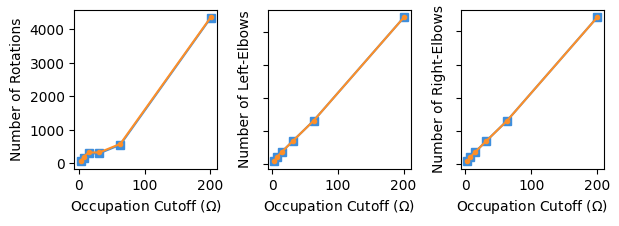

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(16 / 2.54, 6 / 2.54))

numbers_of_terms = [DATA_POINT["USP"]["number_of_terms"] for DATA_POINT in DATA_FOR_FIXED_I]
M_vals = [DATA_POINT["USP"]["maximum_number_of_active_bosonic_modes"] for DATA_POINT in DATA_FOR_FIXED_I]
# rotation_upper_bound = [(L*M*(fix_Omega+3)) for L, M in zip(numbers_of_terms, M_vals)]
# elbow_upper_bound = [(L + L*I + L*M*(fix_Omega + np.log2(fix_Omega))) for L, M, I in zip(numbers_of_terms, M_vals, number_of_modes_range)]

left_elbows_usp = [DATA_POINT["USP"]["left_elbows"] for DATA_POINT in DATA_FOR_FIXED_I]
right_elbows_usp = [DATA_POINT["USP"]["right_elbows"] for DATA_POINT in DATA_FOR_FIXED_I]
rotations_usp = [DATA_POINT["USP"]["rotations"] for DATA_POINT in DATA_FOR_FIXED_I]
nonclifford_rotations_usp = [DATA_POINT["USP"]["number_of_nonclifford_rotations"] for DATA_POINT in DATA_FOR_FIXED_I]
rescaling_factors_usp = [DATA_POINT["USP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_I]
numbers_of_qubits_usp = [DATA_POINT["USP"]["number_of_qubits"] for DATA_POINT in DATA_FOR_FIXED_I]
numbers_of_ancillae_usp = [DATA_POINT["USP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_I]

left_elbows_asp = [DATA_POINT["ASP"]["left_elbows"] for DATA_POINT in DATA_FOR_FIXED_I]
right_elbows_asp = [DATA_POINT["ASP"]["right_elbows"] for DATA_POINT in DATA_FOR_FIXED_I]
rotations_asp = [DATA_POINT["ASP"]["rotations"] for DATA_POINT in DATA_FOR_FIXED_I]
nonclifford_rotations_asp = [DATA_POINT["ASP"]["number_of_nonclifford_rotations"] for DATA_POINT in DATA_FOR_FIXED_I]
rescaling_factors_asp = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_I]
numbers_of_qubits_asp = [DATA_POINT["ASP"]["number_of_qubits"] for DATA_POINT in DATA_FOR_FIXED_I]
numbers_of_ancillae_asp = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_I]

axes[0].plot(occupation_cutoff_range, nonclifford_rotations_usp, color=BLUE, marker='s', alpha = 1)
axes[0].plot(occupation_cutoff_range, nonclifford_rotations_asp, color=ORANGE, marker='.', alpha = 1)
# axes[0].plot(occupation_cutoff_range, rotation_upper_bound, color=RED, ls='--', alpha = 1)
axes[0].set_ylabel("Number of Rotations")
axes[0].set_xlabel("Occupation Cutoff ($\\Omega$)")

axes[1].plot(occupation_cutoff_range, left_elbows_usp, color=BLUE, marker='s', alpha = 1)
axes[1].plot(occupation_cutoff_range, left_elbows_asp, color=ORANGE, marker='.', alpha = 1)
# axes[1].plot(occupation_cutoff_range, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[1].set_ylabel("Number of Left-Elbows")
axes[1].set_xlabel("Occupation Cutoff ($\\Omega$)")

axes[2].plot(occupation_cutoff_range, right_elbows_usp, color=BLUE, marker='s', alpha = 1)
axes[2].plot(occupation_cutoff_range, right_elbows_asp, color=ORANGE, marker='.', alpha = 1)
# axes[2].plot(occupation_cutoff_range, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[2].set_ylabel("Number of Right-Elbows")
axes[2].set_xlabel("Occupation Cutoff ($\\Omega$)")

axes[0].set_yticks([0, 1000, 2000, 3000, 4000])
axes[1].set_yticks([0, 1000, 2000, 3000, 4000])
axes[2].set_yticks([0, 1000, 2000, 3000, 4000])
axes[0].set_yticklabels([0, 1000, 2000, 3000, 4000])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

plt.tight_layout()

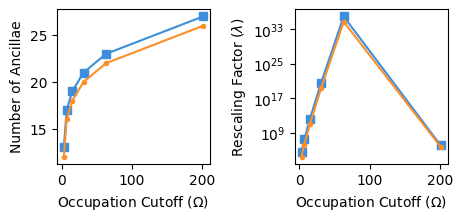

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12 / 2.54, 6 / 2.54))

# axes[0].plot(occupation_cutoff_range, numbers_of_qubits_usp, color=BLUE, marker='s', alpha = 1)
# axes[0].plot(occupation_cutoff_range, numbers_of_qubits_asp, color=ORANGE, marker='.', alpha = 1)
# axes[0].set_ylabel("Number of Qubits")
# axes[0].set_xlabel("Occupation Cutoff ($\\Omega$)")

axes[0].plot(occupation_cutoff_range, numbers_of_ancillae_usp, color=BLUE, marker='s', alpha = 1)
axes[0].plot(occupation_cutoff_range, numbers_of_ancillae_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].set_ylabel("Number of Ancillae")
axes[0].set_xlabel("Occupation Cutoff ($\\Omega$)")

axes[1].plot(occupation_cutoff_range, rescaling_factors_usp, color=BLUE, marker='s', alpha = 1)
axes[1].plot(occupation_cutoff_range, rescaling_factors_asp, color=ORANGE, marker='.', alpha = 1)
axes[1].set_ylabel("Rescaling Factor ($\\lambda$)")
axes[1].set_xlabel("Occupation Cutoff ($\\Omega$)")
axes[1].set_yscale("log")
# axes[1].set_xscale("log")

axes[1].set_yscale('log')
plt.tight_layout()

In [304]:
h, deltaE = Hren_op(Hfull, 2**4 - 1)
h

1.0 * a0^ a0^ a0^ a0^
4.0 * a0^ a0^ a0^ a0
6.0 * a0^ a0^
6.0 * a0^ a0^ a0 a0
13.0 * a0^ a0
4.0 * a0^ a0 a0 a0
6.0 * a0 a0
1.0 * a0 a0 a0 a0
-1.7326138215582737e-07 * a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0
1.5764605981255562e-07 * a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0
-8.092034063199879e-08 * a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0
3.021738999247975e-08 * a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0
-3.862864838057474e-08 * a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0
3.542350048953457e-08 * a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0
-3.862864838057474e-08 * a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0^ a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0 a0
3.542350048953457e-08 * a0^ a